In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

In [2]:
"""Load Escape Fraction Data and antibody classes being used"""
import pandas as pd
import numpy as np
Escape_Fraction = pd.read_csv("Data/escape_fraction_per_site.csv")
Ab_classes = np.unique(Escape_Fraction["ab_class"])
"""Load Infection Data"""
df = pd.read_csv('Data/caseAscertainmentTable_sinceFeb21.csv')
infection_data = df['minNTrue'].values

In [3]:
"""Parameterization for Antibody PK"""
import numpy as np
t = np.arange(1, len(df['date'])+1, 1) # array of timepoints at which to compute the antibody concentration
N = len(Ab_classes) # number of antibody classes
t_max = 14*np.ones(N) # time for the peak of antibody concentration for each antibody class
t_half = 48*np.ones(N) # antibody half-life for all antibody classes, respecively
params_dic = {"t_max":t_max, "t_half":t_half}

In [4]:
"""Compute Antibody concentration over time"""
from Methods.PK import Antibody
is_log = False # if True, it returns the log of the antibody concentration
dataname = "Ab_%d"%N
solver = "lm" # root solver method for finding absorption rate ka (see scipy.optimize.root)
c_t, c_dframe, ka, ke, c_max_dic = Antibody(t = t, params_dic = params_dic, is_log = is_log, Ab_names = Ab_classes, save_to = "Data/"+dataname+".csv", ka_solver = solver)
print(c_dframe, "\n k_a:", ka, "\n k_e:", ke, "\n c_max", c_max_dic)


 k_a was found correctly: True 

     Days   class 1   class 2   class 3   class 4
0       1  0.223579  0.223579  0.223579  0.223579
1       2  0.402809  0.402809  0.402809  0.402809
2       3  0.545897  0.545897  0.545897  0.545897
3       4  0.659540  0.659540  0.659540  0.659540
4       5  0.749201  0.749201  0.749201  0.749201
..    ...       ...       ...       ...       ...
720   721  0.000040  0.000040  0.000040  0.000040
721   722  0.000039  0.000039  0.000039  0.000039
722   723  0.000039  0.000039  0.000039  0.000039
723   724  0.000038  0.000038  0.000038  0.000038
724   725  0.000037  0.000037  0.000037  0.000037

[725 rows x 5 columns] 
 k_a: [0.20336709 0.20336709 0.20336709 0.20336709] 
 k_e: [0.01444057 0.01444057 0.01444057 0.01444057] 
 c_max {'class 1': 0.7589476904838786, 'class 2': 0.7589476904838786, 'class 3': 0.7589476904838786, 'class 4': 0.7589476904838786}


(<Figure size 700x500 with 1 Axes>,
 <AxesSubplot:xlabel='time (days)', ylabel='$c_t$ (normalized)'>)

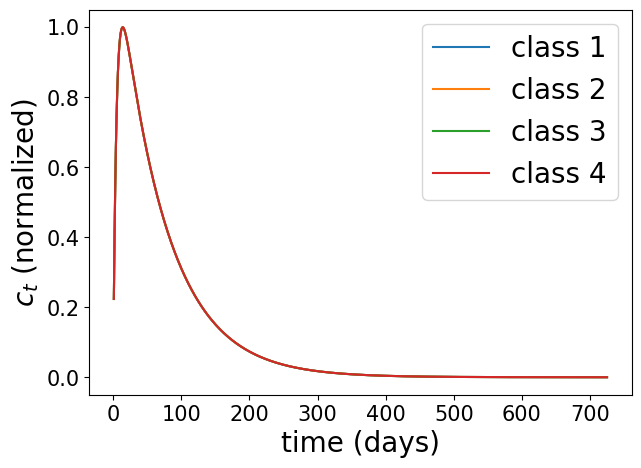

In [5]:
"""Plot Antibody concentration only if t is an array and save, default png but add extension .pdf to save as pdf"""
from Methods.figure_settings import Display
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (7, 5) # figure (width, height)
labels = c_dframe.columns[1:] # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "$c_t$ (normalized)" # name of variable on y axis
Display(t, c_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/"+dataname+".pdf",
        xval = xval, yval = yval)

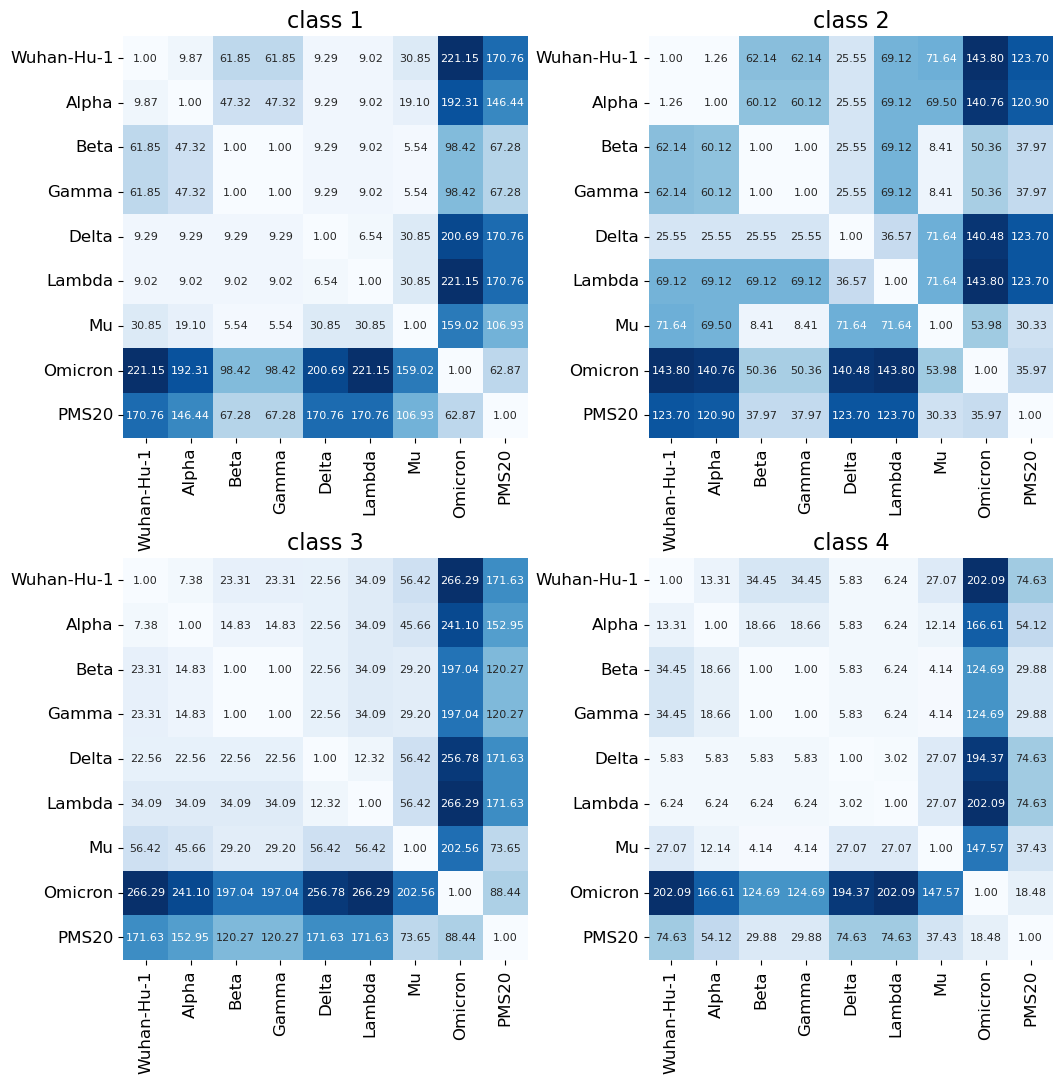

In [7]:
"""Load variants data"""
variant_name = ["Wuhan-Hu-1", "Alpha", "Beta", "Gamma", "Delta", "Lambda", "Mu", "Omicron", "PMS20"]
mut_sites_per_variant = {"Wuhan-Hu-1": [],
                         "Alpha": [501],
                         "Beta": [417, 484, 501],
                         "Gamma": [417, 484, 501],
                         "Delta": [452, 478],
                         "Lambda": [452, 490],
                         "Mu": [346, 484, 501],
                         "Omicron":[339, 371, 373, 375, 417, 440, 446, 477, 478, 484, 493, 496, 498, 501, 505],
                         "PMS20":[346, 417, 440, 445, 455, 475, 484, 501]}

""" Compute cross reactivity map """
from Methods.IE_Projection import cross_reactivity
Cross_react_dic = cross_reactivity(variant_name, Escape_Fraction, Ab_classes, mut_sites_per_variant)

"""Plot Cross Reactivity Map"""
from Methods.figure_settings import Heatmap
import seaborn as sns
fig = Heatmap(data_dic = Cross_react_dic, 
        row_labels = variant_name,
        col_labels = variant_name,
        annotsize = 8,
        colormap = sns.color_palette("Blues", as_cmap=True),
        save_to = "Figures/cross_reactivity",
        sub_fig_size = 6)

In [13]:
"""Load non normalized IC50xx data """
IC50xx_orig = pd.read_csv('Data/IC50xx_per_Ab_class.csv')
# normalize IC50xx by c_max
IC50xx = {}
IC50xx_orig2 = {}
"""Compute normalized IC50xx data (because we are working with normalized antibody dynamics in PK)"""
for ab in Ab_classes:
    IC50xx_orig2[ab] = float(IC50xx_orig[ab])
    IC50xx[ab] = float(IC50xx_orig[ab]/c_max_dic[ab])
print("Original IC50xx data:\n", IC50xx_orig2, "\nNormalized IC50xx data:\n", IC50xx)

Original IC50xx data:
 {'class 1': 6.115618267794472, 'class 2': 6.735374359331275, 'class 3': 4.929950714287574, 'class 4': 7.605220140398003} 
Normalized IC50xx data:
 {'class 1': 8.058023424375094, 'class 2': 8.87462264367263, 'class 3': 6.495771416267713, 'class 4': 10.020743505457116}


In [24]:
"""variant proportion over time (Data from Sofia) """
prop_seeds = np.random.dirichlet(alpha = np.ones(len(variant_name))/len(variant_name)) # sum(prop_seeds)~1
variant_proportion = np.tile(prop_seeds, (len(t), 1)) 

"""Projection of Immune Efficacy as a function of COV19 variant proportions """


[3.80364659e-05 1.64607462e-01 1.25287505e-01 6.20312057e-01
 2.80181521e-05 2.00245620e-02 3.37142177e-02 3.09428461e-02
 5.04529640e-03] 0.9999999999999997


In [18]:
"""Set up the vaccine efficacy data which is used for fitting"""
from Methods.VE import sqrt_diff, vaccine_efficacy_four_antibodies, vaccine_efficacy_n_antibodies
import matplotlib.pyplot as plt

days = np.array([1,2,3,4,5,6])*28
ve_data_1 = np.array([87.6, 73.3, 62.4, 35.1, 20.4, 17.9])/100
ve_data_2 = np.array([0.92423, 0.87141, 0.76936, 0.59191, 0.52525])
ve_data = [ve_data_1, ve_data_2]

In [ ]:
"""Fit the data using n=1,2,3,...,10 antibodies"""
from scipy.optimize import root

guess = 0.2
for n in range(1,len(t_max)+1):
    ic50 = root(sqrt_diff, guess, args = (days, ve_data, n, c_dframe), method = "lm").x
    print(ic50)
    ve_estimate = np.zeros(170)
    for i in range(170):
        antibody_level = c_dframe.loc[i][1:n+1]
        ve_estimate[i] = vaccine_efficacy_n_antibodies(antibody_level, ic50)
    plt.plot(range(170), ve_estimate, label = "VE estimate w/ "+ str(n) + " AB")

plt.plot(days, ve_data_1,'go', label = "Chemaitelly et al.")
plt.plot(days[0:5], ve_data_2, 'ro', label = "Tartof et al.")
plt.xlabel("Days after 2nd Dose")
plt.ylabel("Vaccine Efficacy")
plt.legend(loc='upper right', shadow=True, fontsize='x-small')

In [ ]:
"""Plot case assertainment data over time"""
import datetime as dt
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df['date']]
population_total = df['pop'].values - np.cumsum(infection_data)
plt.plot(x, infection_data)
plt.ylabel("New Infections", fontsize = 16)
plt.xticks([x[0],x[100],x[200], x[300]], rotation = 45, fontsize = 12)

In [ ]:
""" Calculation of expected reduction in neutralization probability """
from Methods.VE import expected_reduction_infection_prob
days = range(310)
reduction_over_time = np.zeros(310)
for day in days:
    observation_period = days[0:day]
    reduction_over_time[day] = expected_reduction_infection_prob(ic50, observation_period, infection_data[0:day], population_total[0:day], len(t_max), c_dframe)
print("Used ic50", ic50)


In [ ]:
plt.plot(x, reduction_over_time)
plt.ylabel("Expected reduction in infection probability")
plt.xticks([x[0],x[100],x[200], x[300]])

In [ ]:
"""Data on Immune Efficacy against COV19 Wild Type """
days = np.array([1,2,3,4,5,6])*28
ve_data_1 = np.array([87.6, 73.3, 62.4, 35.1, 20.4, 17.9])/100
ve_data_2 = np.array([0.92423, 0.87141, 0.76936, 0.59191, 0.52525])
ve_data = [ve_data_1, ve_data_2]

In [ ]:
""" Projection of Immune Efficacy as a function of COV19 variant proportions """
""" Same as Expected reduction in infection probability but considering several variants """
np.random.seed(7)
infected = infection_data
tot_pop = df['pop'].values - np.cumsum(infected)
variant_name = ["Var 1", "Var 2", "Var 3", "other"]
variant_proportion = np.tile(np.array([0.20, 0.30, 0.40, 0.10]), (len(t), 1)) # variant proportion might change over time
#variant_proportion = np.tile(np.array([0.25, 0.25, 0.25, 0.25]), (len(t), 1))
fold_resistance = [1.2, 1.4, 1.6, 1.8]
#fold_resistance = [1., 1., 1., 1.]

variant_data = {"name":variant_name, "proportion":variant_proportion, "fold resistance":fold_resistance}
antibody_data = {"t_max": t_max, "t_half":t_half, "day_activation":0} # assuming antibodies are activated 0 days after infection
VE_data_wild = {"days":days, "Efficacy":ve_data}

In [ ]:
from Methods.IE_Projection import IE_Per_Variant
IE_dic = IE_Per_Variant(t, infected, tot_pop, antibody_data, VE_data_wild, variant_data)

In [ ]:
"""Plot Projection, default png but add extension .pdf to save as pdf"""
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
labels = variant_name # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "Expected Immune Efficacy Proba" # name of variable on y axis
prob_neut_t = np.row_stack(tuple([IE_dic[variant_name[i]] for i in range(len(variant_name))]))
Display(t, prob_neut_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/IE_Projection.pdf",
        xval = xval, yval = yval)
plt.legend(fontsize = labsize, loc = (1.1, 0.5))

In [ ]:
"Total projected Immune Efficacy proba"
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
labels = ["All variants"] # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "Expected Immune Efficacy Proba" # name of variable on y axis
IE_t = np.row_stack(tuple([IE_dic[variant_name[i]] for i in range(len(variant_name))]))
tot_IE_t = np.array([np.sum(IE_t, axis = 0)])
Display(t, tot_IE_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/Total_IE_Projection.pdf",
        xval = xval, yval = yval)
plt.legend(fontsize = labsize, loc = (1.1, 0.5))